# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import warnings
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from scipy.sparse import csr_matrix
from scipy import sparse
from sklearn import metrics
from sklearn import preprocessing
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from bs4 import BeautifulSoup
from wordcloud import WordCloud 
from sklearn.neighbors import NearestNeighbors
from random import randint
from scipy.cluster.hierarchy import dendrogram

from collections import defaultdict
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.tree import export_graphviz
from IPython.display import Image
import pydotplus
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

from tqdm import tqdm
import os

In [4]:
# using SQLite Table to read data.
con = sqlite3.connect('C:\\Users\\rahul\\Desktop\\AI COURSE\\Amazon Fine food\\amazon-fine-food-reviews (1)\\database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [7]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [12]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [8]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [9]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [10]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college
I was really looking forward to these pods based on the reviews.  Starbucks is good, but I prefer bolder taste.... imagine my surprise when I ordered 2 boxes - both were expired! One expired back in 2005 for gosh sakes.  I admit that Amazon agreed to credit me for cost plus part of shipping, but geez, 2 years expired!!!  I'm hoping to find local San Diego area shoppe that carries pods so that I can try something different than starbucks.
Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a do

In [11]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [12]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great ingredients although, chicken should have been 1st rather than chicken broth, the only thing I do not think belongs in it is Canola oil. Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it, it would poison them. Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut, facts though say otherwise. Until the late 70 is it was poisonous until they figured out a way to fix that. I still like it but it could be better.


In [11]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

this witty little book makes my son laugh at loud. i recite it in the car as we're driving along and he always can sing the refrain. he's learned about whales, India, drooping roses:  i love all the new words this book  introduces and the silliness of it all.  this is a classic book i am  willing to bet my son will STILL be able to recite from memory when he is  in college


In [12]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great ingredients although chicken should have been 1st rather than chicken broth the only thing I do not think belongs in it is Canola oil Canola or rapeseed is not someting a dog would ever find in nature and if it did find rapeseed in nature and eat it it would poison them Today is Food industries have convinced the masses that Canola oil is a safe and even better oil than olive or virgin coconut facts though say otherwise Until the late 70 is it was poisonous until they figured out a way to fix that I still like it but it could be better 


In [13]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [14]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
final = final.sample(n=100000)
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:50<00:00, 1976.65it/s]


In [15]:
preprocessed_reviews[1500]

'burned sticks far hem lavender described smooth deep peaceful lavender scent not sharp edge lavender usually carries like edge therefore give item not stars not seen package might not guess lavender nice scent without overly floral described audiences type lavender males females home enjoy scent scent good enough part standard stock enjoy morning since peaceful without sleepy looking add calm chaotic home try lavender'

# [4] Featurization

## [4.1] BAG OF WORDS

In [25]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [26]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [27]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [28]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [42]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [36]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [38]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [39]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [41]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [25]:
# Please write all the code with proper documentation
final['preprocessed_reviews']=preprocessed_reviews

final['Score'].value_counts()

label = final['Score']

final1 = final.sample(n=100000)

type(final)
print(final1.head(3))

#Bag of words using Scikit learn
count_vect = CountVectorizer(min_df=5,max_features=500)
X_bow = count_vect.fit_transform(final1['preprocessed_reviews'].values)
type(count_vect)

print(X_bow.shape)


            Id   ProductId          UserId      ProfileName  \
392887  424845  B0041CIP3M  A1B6O7SAIYG2N0      Jacx "J.C."   
51948    56432  B000EHL21U   AXECMQ5UEC230  Donna J. Jacobs   
241673  262117  B000LKXCD6  A2QASVB9ZJAIH5     Southern Gal   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
392887                     0                       0      1  1329004800   
51948                      0                       2      1  1291334400   
241673                     0                       0      1  1332892800   

                               Summary  \
392887                   hot and spicy   
51948   EXPIRATION DATES SUCK FOR THIS   
241673   Very happy with this product!   

                                                     Text  \
392887  This turned out to be a very tasty dish. It sa...   
51948   I bought these bars to use in my "hurricane fo...   
241673  Just had this for the first time over basmati ...   

                                

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

def kmeans_cluster(x):
    
    k_list = list(range(5,71,5))
    inertia_scores = []
    
    for k in k_list:
        kmeans = KMeans(n_clusters=k, random_state=0,n_jobs=-1).fit(x)
        inertia_scores.append(kmeans.inertia_)
    
    plt.figure(figsize=(16,8))
    plt.plot(k_list, inertia_scores)

    for xy in zip(k_list, np.round(inertia_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Number of Clusters K')
    plt.ylabel('Squared Distances to cluster/INertia')
    plt.show()

    return None 

def find_eps_dbscan(x):
    #SOURCE: https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(x)
    distances, indices = nbrs.kneighbors(x)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.figure(figsize=(16,8))
    plt.title('Elbow Curve using minimum neighbourhood distance')  
    plt.plot(distances)
    plt.xlabel('Points')
    plt.ylabel('Epsilon value')
    plt.show()
        
#Function to generate wordcloud given a list of words
def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(relative_scaling = 1.0 ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

#source: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html    
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)



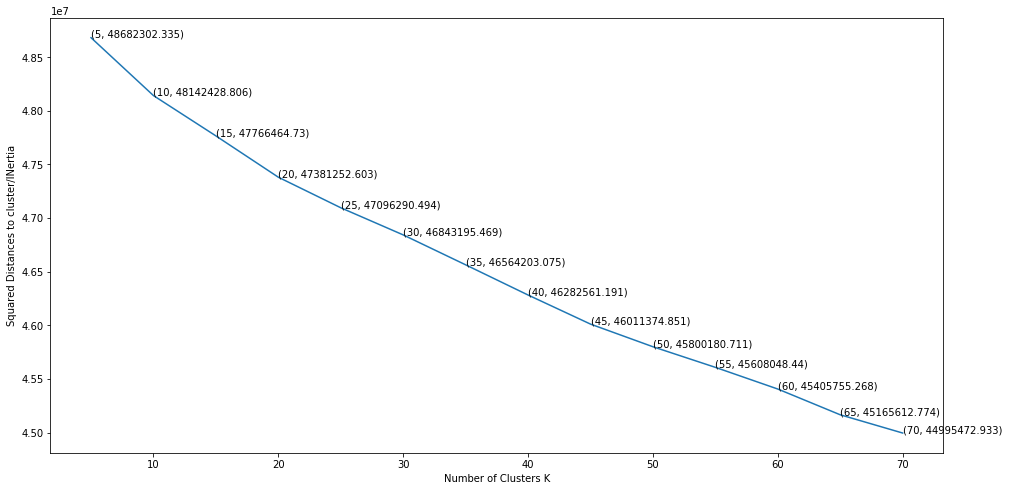

In [26]:
#find the optimal number of cluster for kmeans
X_bow = StandardScaler(copy=True, with_mean=False, with_std=True).fit_transform(X_bow) 

kmeans_cluster(X_bow)


In [27]:
#As we see that the inertia continues to decrease even after 70 we will pick a suitable number of clusters of our choice

kmeans_clustering = KMeans(n_clusters=50, random_state=0,n_jobs=-1)
kmeans_clustering.fit_predict(X_bow)
print((kmeans_clustering.labels_))

[ 4  5 29 ...  1 25 29]


In [31]:
text = final1['preprocessed_reviews'].to_numpy()
print(text.shape)

text = text.reshape(len(text),1)
labels = kmeans_clustering.labels_.reshape(len(kmeans_clustering.labels_),1)
print(labels.shape)
clustered_text = np.concatenate((labels,text),axis=1)
print(clustered_text.shape)

(100000,)
(100000, 1)
(100000, 2)


In [32]:
# https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/43094244
#create a list of words for each cluster

cluster_dict = defaultdict(list)
for key, val in clustered_text:
    cluster_dict[key].append(val)

clusters = cluster_dict.values()
clust_text = []
for i in clusters:
    clust_text.append(" ".join(i))
print(len(clust_text))

50


The most common 25 words in cluster 29 is: 


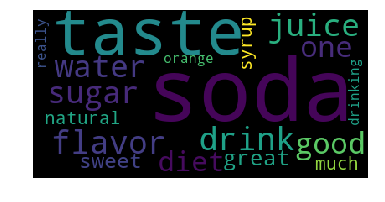

The most common 25 words in cluster 26 is: 


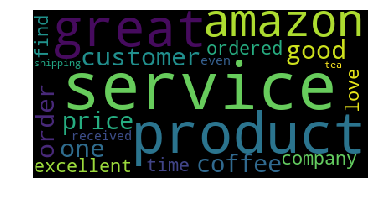

The most common 25 words in cluster 10 is: 


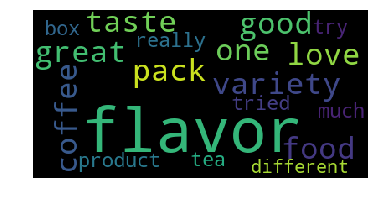

The most common 25 words in cluster 9 is: 


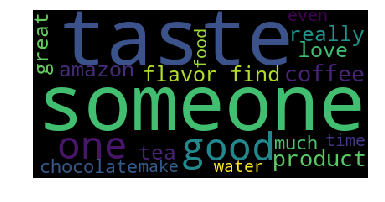

The most common 25 words in cluster 19 is: 


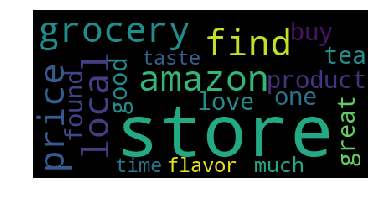

In [36]:
#as it would be difficult to visualize all the 50 clusters, lets randomly pick any 5 and visualize them

rand_clusters = 5
n_clusters = 50

clust_words =[]
for i in range(n_clusters):
    clust_words.append(clust_text[i].split())

most_common_words = []

#count the occurence of each word in the cluster and sort the top 25 words 
#Source: https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list
for i in range(rand_clusters):
    j= randint(0,49)
    most_common_words.append([word for word, word_count in Counter(clust_words[j]).most_common(25)])
    top_text = " ".join(words for words in most_common_words[i])
    print("The most common 25 words in cluster {} is: ".format(j+1))
    generate_wordcloud(top_text)

Conclusion:
    1. K-means Clustering was performed on BOW representation of AFF.
    2. From the plot of number of clusters vs inertia, it could be seen that the distance continues to decrease even after 70 clusters. 
    3. This could be due to high dimensions/curse of dimensionality among others
    4. We chose a cluster value of 50 and randomly visualized 5 clusters among them.
    5. Among the visualizations we could figure that some of these clusters are well clustered like Cluster 29: juice,syrup,sweet,sugar diet meaning it could relate to a beverage. Similarly cluster 26 has words like customer,shipping, price,amazon,order,received which could relate to custome shopping experience! However there were some clusters which had a wide variety of words which makes it difficult to pin down to a particular category.

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [14]:
#Bag of words using Scikit learn
final['preprocessed_reviews']=preprocessed_reviews
tfidf_vect = TfidfVectorizer(ngram_range=(1,2),min_df=5,max_features=500)
X_tfidf = tfidf_vect.fit_transform(final['preprocessed_reviews'].values)
type(tfidf_vect)

print(X_tfidf.shape)

(100000, 500)


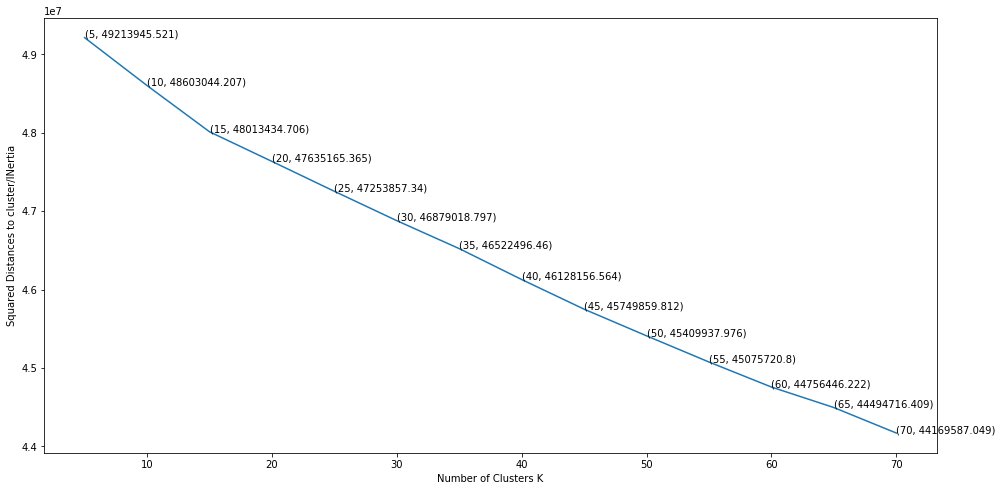

In [30]:
#find the optimal number of cluster for kmeans
X_tfidf = StandardScaler(copy=True, with_mean=False, with_std=True).fit_transform(X_tfidf) 

kmeans_cluster(X_tfidf)


In [15]:
#As we see that the inertia continues to decrease even after 70 we will pick a suitable number of clusters of our choice

kmeans_clustering = KMeans(n_clusters=50, random_state=0,n_jobs=-1)
kmeans_clustering.fit_predict(X_tfidf)
print((kmeans_clustering.labels_))

[22 35 11 ...  9 26 30]


In [18]:
text = final['preprocessed_reviews'].to_numpy()
print(text.shape)

text = text.reshape(len(text),1)
labels = kmeans_clustering.labels_.reshape(len(kmeans_clustering.labels_),1)
print(labels.shape)
clustered_text = np.concatenate((labels,text),axis=1)
print(clustered_text.shape)

(100000,)
(100000, 1)
(100000, 2)


In [19]:
# https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/43094244
#create a list of words for each cluster

cluster_dict = defaultdict(list)
for key, val in clustered_text:
    cluster_dict[key].append(val)

clusters = cluster_dict.values()
clust_text = []
for i in clusters:
    clust_text.append(" ".join(i))
print(len(clust_text))

50


The most common 25 words in cluster 39 is: 


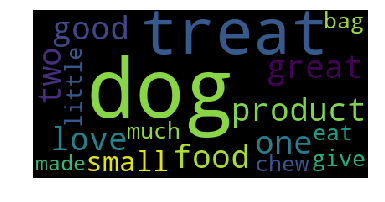

The most common 25 words in cluster 5 is: 


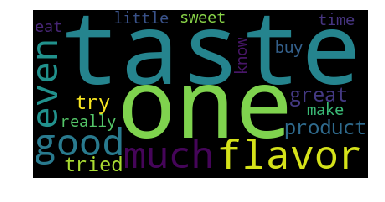

The most common 25 words in cluster 41 is: 


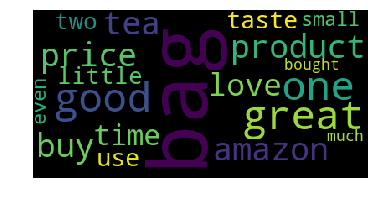

The most common 25 words in cluster 42 is: 


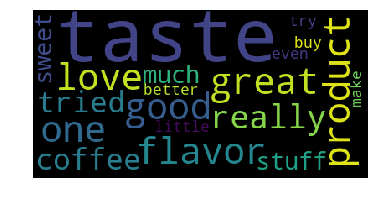

The most common 25 words in cluster 47 is: 


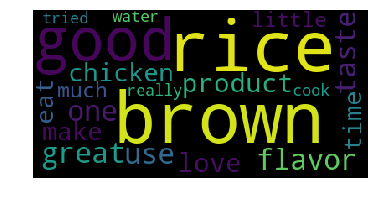

In [20]:
#as it would be difficult to visualize all the 50 clusters, lets randomly pick any 5 and visualize them

rand_clusters = 5
n_clusters = 50

clust_words =[]
for i in range(n_clusters):
    clust_words.append(clust_text[i].split())

most_common_words = []

#count the occurence of each word in the cluster and sort the top 25 words 
#Source: https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list
for i in range(rand_clusters):
    j= randint(0,49)
    most_common_words.append([word for word, word_count in Counter(clust_words[j]).most_common(25)])
    top_text = " ".join(words for words in most_common_words[i])
    print("The most common 25 words in cluster {} is: ".format(j+1))
    generate_wordcloud(top_text)

Conclusion:
    1. K-means Clustering was performed on TFIDF representation of AFF.
    2. From the plot of number of clusters vs inertia, it could be seen that the distance continues to decrease even after 70 clusters. 
    3. This could be due to high dimensions/curse of dimensionality among others
    4. We chose a cluster value of 50 and randomly visualized 5 clusters among them.
    5. Among the visualizations we could figure that some of these clusters are well clustered like Cluster 39: dog,little,food,chew meaning it could relate to a 'pet food'. Similarly cluster 47 has words like chicken,rice,cook,brown,flavour which could relate to a Asian food item! However there were some clusters which had a wide variety of words which makes it difficult to pin down to a particular category.

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [21]:
# Please write all the code with proper documentation
final1['preprocessed_reviews']=preprocessed_reviews

final1['Score'].value_counts()

label = final1['Score']

type(final)

i=0

list_of_sentance=[]
for sentance in final['preprocessed_reviews']:
    list_of_sentance.append(sentance.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

# average Word2Vec
# compute average word2vec for each review.
w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    w2v_vectors.append(sent_vec)
print(len(w2v_vectors))
print(len(w2v_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████| 100000/100000 [04:31<00:00, 368.25it/s]


100000
50


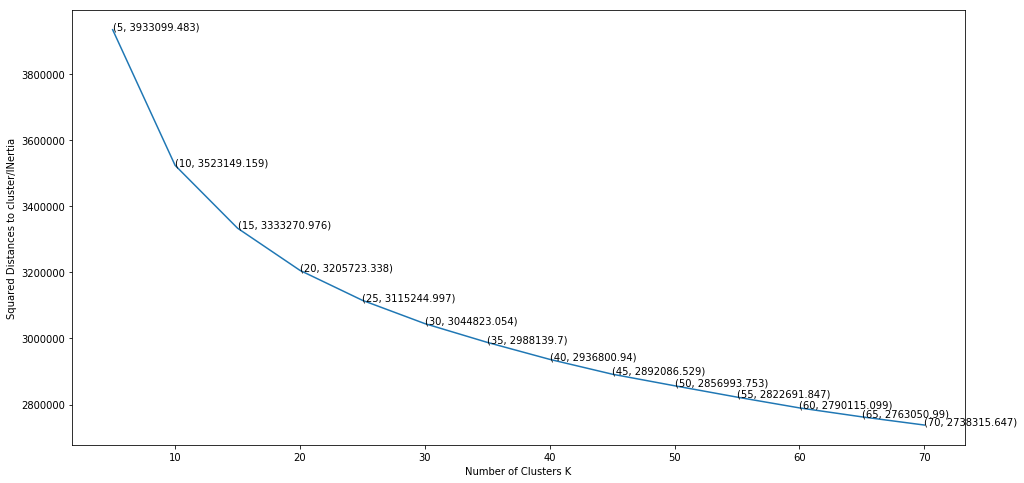

In [22]:
#find the optimal number of cluster for kmeans
X_w2v = StandardScaler(copy=True, with_mean=False, with_std=True).fit_transform(w2v_vectors) 

kmeans_cluster(X_w2v)

In [23]:
#As we see that the inertia continues to decrease even after 70 we will pick a suitable number of clusters of our choice

kmeans_clustering = KMeans(n_clusters=50, random_state=0,n_jobs=-1)
kmeans_clustering.fit_predict(X_w2v)
print((kmeans_clustering.labels_))

[10 42 37 ... 45 32 41]


In [24]:
labels = kmeans_clustering.labels_.reshape(len(kmeans_clustering.labels_),1)
print(labels.shape)
clustered_text = np.concatenate((labels,text),axis=1)
print(clustered_text.shape)

(100000, 1)
(100000, 2)


In [25]:
# https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/43094244
#create a list of words for each cluster

cluster_dict = defaultdict(list)
for key, val in clustered_text:
    cluster_dict[key].append(val)

clusters = cluster_dict.values()
clust_text = []
for i in clusters:
    clust_text.append(" ".join(i))
print(len(clust_text))

50


The most common 25 words in cluster 13 is: 


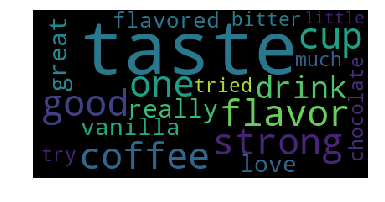

The most common 25 words in cluster 27 is: 


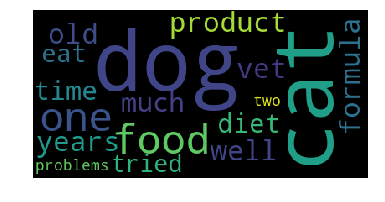

The most common 25 words in cluster 33 is: 


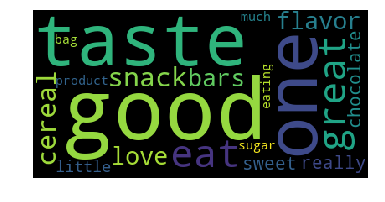

The most common 25 words in cluster 20 is: 


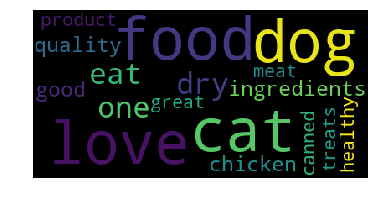

The most common 25 words in cluster 10 is: 


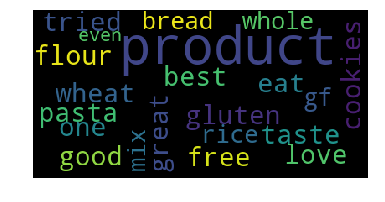

In [26]:
#as it would be difficult to visualize all the 50 clusters, lets randomly pick any 5 and visualize them

rand_clusters = 5
n_clusters = 50

clust_words =[]
for i in range(n_clusters):
    clust_words.append(clust_text[i].split())

most_common_words = []

#count the occurence of each word in the cluster and sort the top 25 words 
#Source: https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list
for i in range(rand_clusters):
    j= randint(0,49)
    most_common_words.append([word for word, word_count in Counter(clust_words[j]).most_common(25)])
    top_text = " ".join(words for words in most_common_words[i])
    print("The most common 25 words in cluster {} is: ".format(j+1))
    generate_wordcloud(top_text)

Conclusion:
    1. K-means Clustering was performed on TFIDF representation of Word2vec.
    2. From the plot of number of clusters vs inertia, it could be seen that the distance continues to decrease even after 70 clusters. 
    3. We chose a cluster value of 50 and randomly visualized 5 clusters among them.
    4. Among the visualizations we could figure that some of these clusters are well clustered like Cluster 13: flavored,bitter,strong,coffee,chocolate,vanilla it could relate to a 'beverage/dessert'. Similarly cluster 33 has words like cereal,snackbar,chocolate,sugar,sweet which could relate to a Snack/breakfast! However there were some clusters which had a wide variety of words which makes it difficult to pin down to a particular category.

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [27]:
# # Please write all the code with proper documentation
# # TF-IDF weighted Word2Vec
#fetching the list of sentences from cleanedtext column of our train data for word2vec model    
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

final1 = final.sample(n=10000)
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
vocab = tf_idf_vect.fit_transform(final1['preprocessed_reviews'].values)

i=0
list_of_sent=[]
for sent in final1['preprocessed_reviews'].values:
    list_of_sent.append(sent.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
    
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

tfidf_w2v_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;


for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_vectors.append(sent_vec)
    row += 1


100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [52:14<00:00,  3.19it/s]


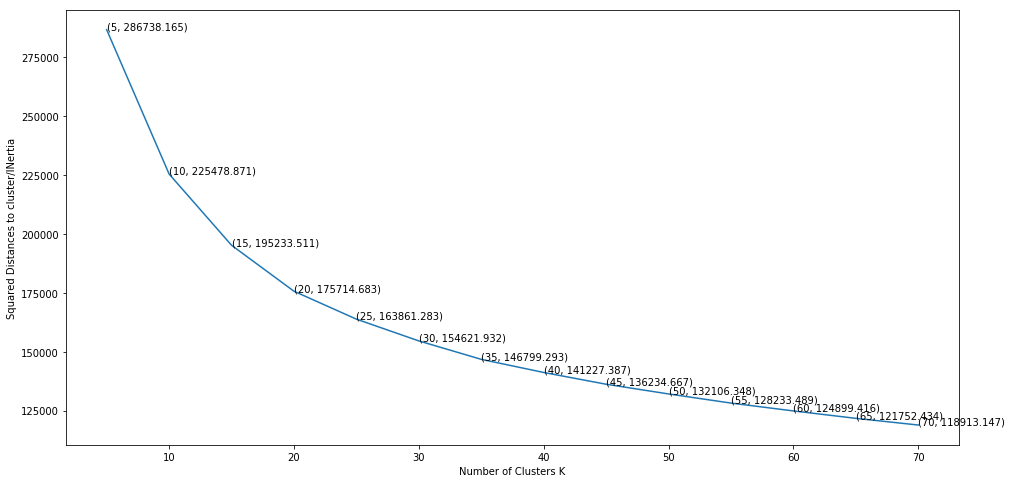

In [28]:
#find the optimal number of cluster for kmeans
X_tfidfw2v = StandardScaler(copy=True, with_mean=False, with_std=True).fit_transform(tfidf_w2v_vectors) 

kmeans_cluster(X_tfidfw2v)

In [29]:
#As we see that the inertia drop is significant at 20, we will pick 20 clusters

kmeans_clustering = KMeans(n_clusters=20, random_state=0,n_jobs=-1)
kmeans_clustering.fit_predict(X_tfidfw2v)
print((kmeans_clustering.labels_))

[ 6  4  6 ... 15  6  5]


In [31]:
text = final1['preprocessed_reviews'].to_numpy()
print(text.shape)

text = text.reshape(len(text),1)
labels = kmeans_clustering.labels_.reshape(len(kmeans_clustering.labels_),1)
print(labels.shape)
clustered_text = np.concatenate((labels,text),axis=1)
print(clustered_text.shape)

(10000,)
(10000, 1)
(10000, 2)


In [32]:
# https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/43094244
#create a list of words for each cluster

cluster_dict = defaultdict(list)
for key, val in clustered_text:
    cluster_dict[key].append(val)

clusters = cluster_dict.values()
clust_text = []
for i in clusters:
    clust_text.append(" ".join(i))
print(len(clust_text))

20


The most common 25 words in cluster 7 is: 


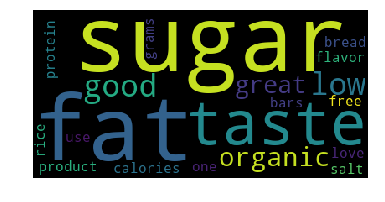

The most common 25 words in cluster 14 is: 


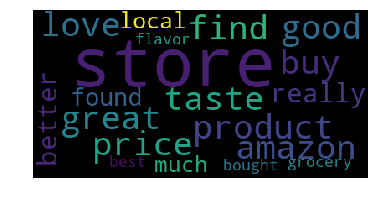

The most common 25 words in cluster 5 is: 


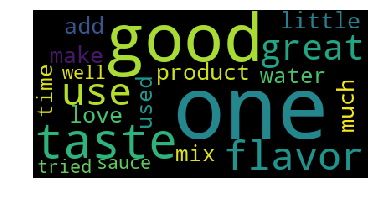

The most common 25 words in cluster 3 is: 


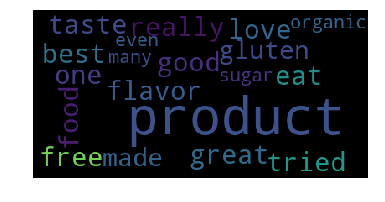

The most common 25 words in cluster 2 is: 


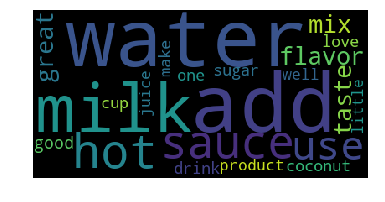

In [33]:
#as it would be difficult to visualize all the 50 clusters, lets randomly pick any 5 and visualize them

rand_clusters = 5
n_clusters = 20

clust_words =[]
for i in range(n_clusters):
    clust_words.append(clust_text[i].split())

most_common_words = []

#count the occurence of each word in the cluster and sort the top 25 words 
#Source: https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list
for i in range(rand_clusters):
    j= randint(0,19)
    most_common_words.append([word for word, word_count in Counter(clust_words[j]).most_common(25)])
    top_text = " ".join(words for words in most_common_words[i])
    print("The most common 25 words in cluster {} is: ".format(j+1))
    generate_wordcloud(top_text)

Conclusion:
    1. K-means Clustering was performed on TFIDF representation of Word2vec.
    2. From the plot of number of clusters vs inertia, it could be seen that there was big decrease until number of clusters were 20. 
    3. We chose a cluster value of 20 and randomly visualized 5 clusters among them.
    4. Among the visualizations we could figure that some of these clusters are well clustered like Cluster 7: fat,low,calorie,organic,protein,bars it could relate to a 'health conscious food item'. Similarly cluster 2 has words like milk,cup,juice,hot,drink,coconut,flavor which could relate to a 'beverage' category! However there were some clusters which had a wide variety of words which makes it difficult to pin down to a particular category.

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [17]:
# Please write all the code with proper documentation
final['preprocessed_reviews']=preprocessed_reviews

final['Score'].value_counts()

label = final['Score']

final1 = final.sample(n=25000)

type(final)
print(final1.head(3))

i=0

list_of_sentance=[]
for sentance in final1['preprocessed_reviews']:
    list_of_sentance.append(sentance.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)

# average Word2Vec
# compute average word2vec for each review.
w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    w2v_vectors.append(sent_vec)
print(len(w2v_vectors))
print(len(w2v_vectors[0]))

            Id   ProductId          UserId    ProfileName  \
30207    32899  B001P05K8Q  A166UG2632WII2     S. Shelton   
521645  563965  B001XSMANI  A35BALA39O1NYU         Thomas   
483018  522268  B006Y7WJRU  A31AJSXS6O5SEP  Joan Kopetsky   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
30207                      0                       0      1  1217635200   
521645                     1                       1      1  1327622400   
483018                     0                       0      0  1347926400   

                                                  Summary  \
30207   Not all EXTRA Large but all EXTRA good...so sa...   
521645      Not 1 single flavor jelly bean I did not like   
483018                                     Not even close   

                                                     Text  \
30207   I agree that there's a problem with the chews ...   
521645  After some folks saying a few of the flavors a...   
483018  I bought this as a

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [00:48<00:00, 517.54it/s]


25000
50


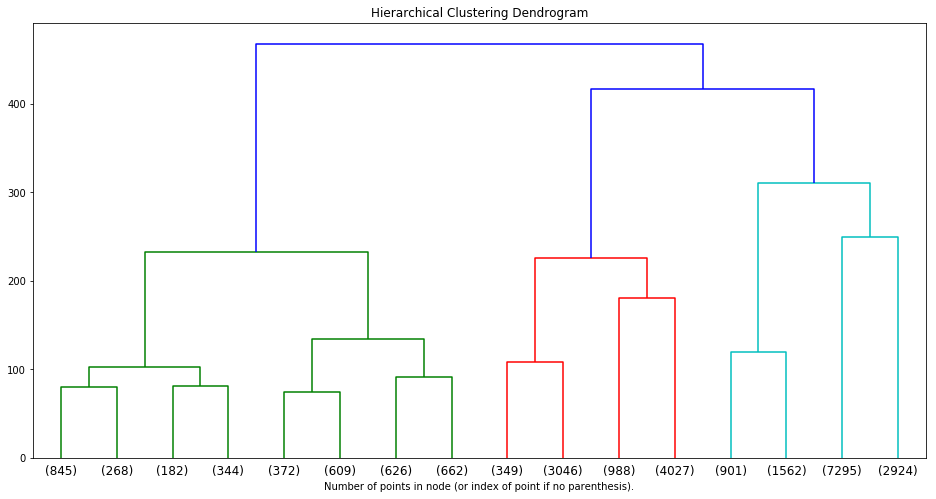

In [19]:
#find the optimal number of cluster for kmeans
X_w2v = StandardScaler(copy=True, with_mean=False, with_std=True).fit_transform(w2v_vectors) 

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0.0,compute_full_tree=True, n_clusters=None)

model = model.fit(X_w2v)
plt.figure(figsize=(16,8))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [20]:
#Based on the above Dendogram, we can choose 8,4 and 3 clusters
agg_clustering = AgglomerativeClustering(n_clusters=8)
agg_clustering.fit_predict(X_w2v)
print((agg_clustering.labels_))

[3 1 2 ... 1 6 6]


In [21]:
text = final1['preprocessed_reviews'].to_numpy()
print(text.shape)

text = text.reshape(len(text),1)
labels = agg_clustering.labels_.reshape(len(agg_clustering.labels_),1)
print(labels.shape)
clustered_text = np.concatenate((labels,text),axis=1)
print(clustered_text.shape)

(25000,)
(25000, 1)
(25000, 2)


In [22]:
text = final1['preprocessed_reviews'].to_numpy()
print(text.shape)

text = text.reshape(len(text),1)
labels = agg_clustering.labels_.reshape(len(agg_clustering.labels_),1)
print(labels.shape)
clustered_text = np.concatenate((labels,text),axis=1)
print(clustered_text.shape)

(25000,)
(25000, 1)
(25000, 2)


In [25]:
# https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/43094244
#create a list of words for each cluster
n_clusters = 8
from collections import defaultdict

cluster_dict = defaultdict(list)
for key, val in clustered_text:
    cluster_dict[key].append(val)

clusters = cluster_dict.values()
clust_text = []
for i in clusters:
    clust_text.append(" ".join(i))
print(len(clust_text))

8


The most common 25 words in cluster 1 is: 


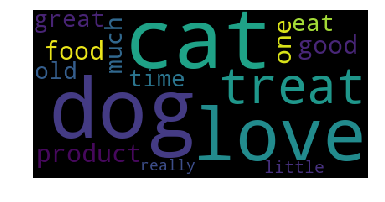

The most common 25 words in cluster 2 is: 


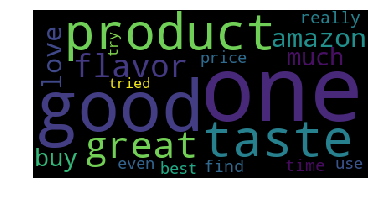

The most common 25 words in cluster 3 is: 


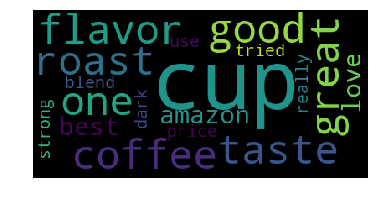

The most common 25 words in cluster 4 is: 


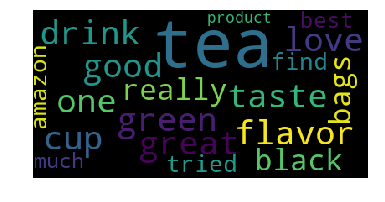

The most common 25 words in cluster 5 is: 


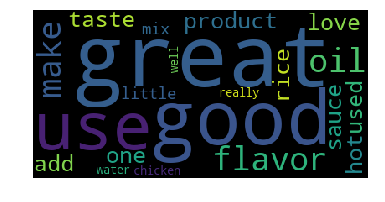

The most common 25 words in cluster 6 is: 


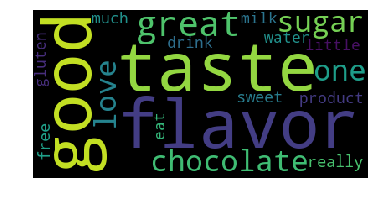

The most common 25 words in cluster 7 is: 


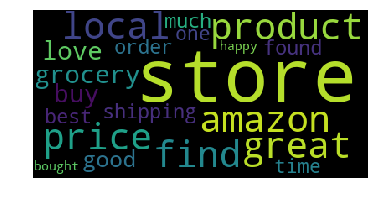

The most common 25 words in cluster 8 is: 


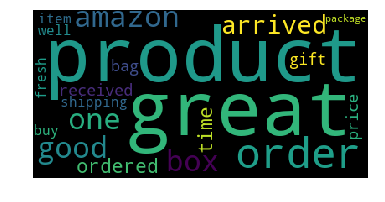

In [26]:
clust_words =[]
for i in range(n_clusters):
    clust_words.append(clust_text[i].split())

most_common_words = []

#count the occurence of each word in the cluster and sort the top 25 words 
#Source: https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list
for i in range(n_clusters):
    most_common_words.append([word for word, word_count in Counter(clust_words[i]).most_common(25)])
    top_text = " ".join(words for words in most_common_words[i])
    print("The most common 25 words in cluster {} is: ".format(i+1))
    generate_wordcloud(top_text)

In [27]:
#Try with different number of clusters 5
agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_clustering.fit_predict(X_w2v)
print((agg_clustering.labels_))

[3 0 1 ... 0 2 2]


In [28]:
labels = agg_clustering.labels_.reshape(len(agg_clustering.labels_),1)
print(labels.shape)
clustered_text = np.concatenate((labels,text),axis=1)
print(clustered_text.shape)

(25000, 1)
(25000, 2)


In [29]:
# https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/43094244
#create a list of words for each cluster
n_clusters = 4
from collections import defaultdict

cluster_dict = defaultdict(list)
for key, val in clustered_text:
    cluster_dict[key].append(val)

clusters = cluster_dict.values()
clust_text = []
for i in clusters:
    clust_text.append(" ".join(i))
print(len(clust_text))

4


The most common 25 words in cluster 1 is: 


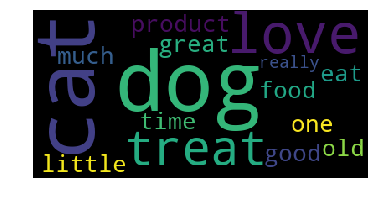

The most common 25 words in cluster 2 is: 


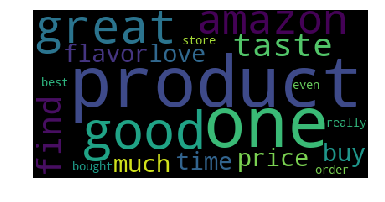

The most common 25 words in cluster 3 is: 


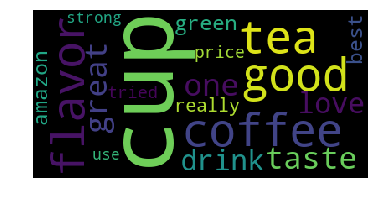

The most common 25 words in cluster 4 is: 


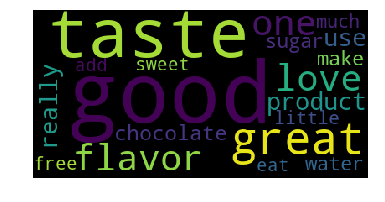

In [30]:
clust_words =[]
for i in range(n_clusters):
    clust_words.append(clust_text[i].split())

most_common_words = []

#count the occurence of each word in the cluster and sort the top 25 words 
#Source: https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list
for i in range(n_clusters):
    most_common_words.append([word for word, word_count in Counter(clust_words[i]).most_common(25)])
    top_text = " ".join(words for words in most_common_words[i])
    print("The most common 25 words in cluster {} is: ".format(i+1))
    generate_wordcloud(top_text)

In [31]:
#Try with different number of clusters 3
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_clustering.fit_predict(X_w2v)
print((agg_clustering.labels_))

[0 0 1 ... 0 2 2]


In [32]:
labels = agg_clustering.labels_.reshape(len(agg_clustering.labels_),1)
print(labels.shape)
clustered_text = np.concatenate((labels,text),axis=1)
print(clustered_text.shape)

(25000, 1)
(25000, 2)


In [33]:
# https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/43094244
#create a list of words for each cluster
n_clusters = 3
from collections import defaultdict

cluster_dict = defaultdict(list)
for key, val in clustered_text:
    cluster_dict[key].append(val)

clusters = cluster_dict.values()
clust_text = []
for i in clusters:
    clust_text.append(" ".join(i))
print(len(clust_text))

3


The most common 25 words in cluster 1 is: 


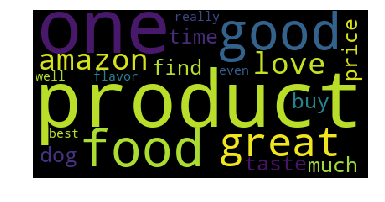

The most common 25 words in cluster 2 is: 


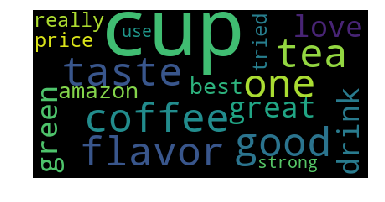

The most common 25 words in cluster 3 is: 


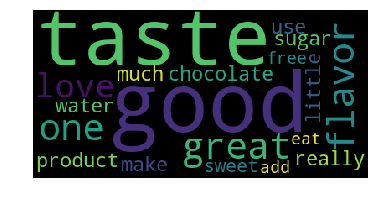

In [34]:
clust_words =[]
for i in range(n_clusters):
    clust_words.append(clust_text[i].split())

most_common_words = []

#count the occurence of each word in the cluster and sort the top 25 words 
#Source: https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list
for i in range(n_clusters):
    if(clust_words[i]):
        most_common_words.append([word for word, word_count in Counter(clust_words[i]).most_common(25)])
        top_text = " ".join(words for words in most_common_words[i])
        print("The most common 25 words in cluster {} is: ".format(i+1))
        generate_wordcloud(top_text)
    else:
        print("There are no words found in cluster {} ".format(i+1))

Conclusion:
    1. Agglomerative Clustering was performed on Word2vec representation of AFF.
    2. We chose multiple cluster values like 2,3 and 5. we visualized these clusters using wordcloud.
    3. AS these clusters had a wide variety of words, it made it difficult to pin down to a particular category. This could be due to vey few points considered due to computational constraints or randomness in our data points. Also, interestingly we found clusters that had no data points i.e empty clusters were found when cluster size was 5

### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [59]:
# # Please write all the code with proper documentation
# # TF-IDF weighted Word2Vec
#fetching the list of sentences from cleanedtext column of our train data for word2vec model    
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

final1 = final.sample(n=25000)
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf
vocab = tf_idf_vect.fit_transform(final1['preprocessed_reviews'].values)

i=0
list_of_sent=[]
for sent in final1['preprocessed_reviews'].values:
    list_of_sent.append(sent.split())

# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
    
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

tfidf_w2v_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;


for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_w2v_vectors.append(sent_vec)
    row += 1


100%|██████████████████████████████████████████████████████████████████████████| 25000/25000 [4:38:45<00:00,  2.42it/s]


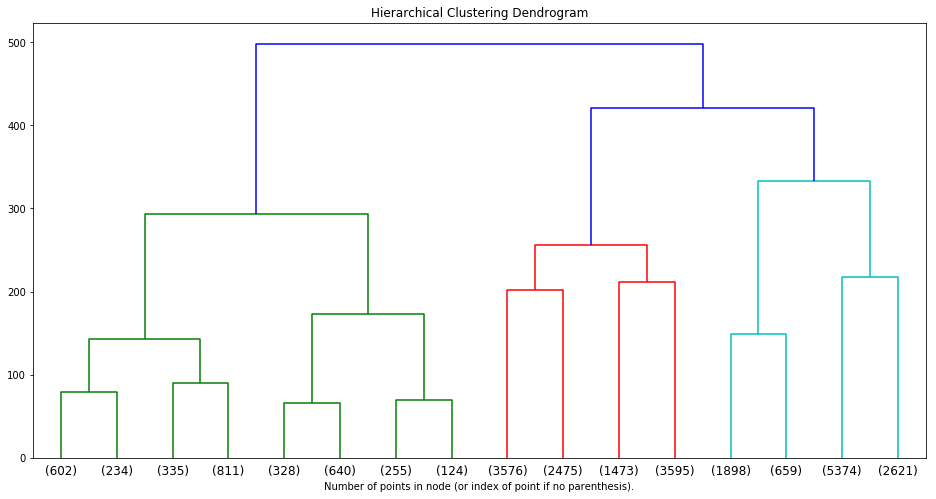

In [60]:
#find the optimal number of cluster for kmeans
X_tfidfw2v = StandardScaler(copy=True, with_mean=False, with_std=True).fit_transform(tfidf_w2v_vectors) 

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0.0,compute_full_tree=True, n_clusters=None)

model = model.fit(X_tfidfw2v)
plt.figure(figsize=(16,8))
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [61]:
#AS we can see from Dendogram, we can have 8,4 and 3 clusters
X_tfidfw2v = StandardScaler(copy=True, with_mean=False, with_std=True).fit_transform(tfidf_w2v_vectors) 

agg_clustering = AgglomerativeClustering(n_clusters=8)
agg_clustering.fit_predict(X_tfidfw2v)
print((agg_clustering.labels_))

[1 7 5 ... 0 7 6]


In [62]:
text = final1['preprocessed_reviews'].to_numpy()
print(text.shape)

text = text.reshape(len(text),1)
labels = agg_clustering.labels_.reshape(len(agg_clustering.labels_),1)
print(labels.shape)
clustered_text = np.concatenate((labels,text),axis=1)
print(clustered_text.shape)

(25000,)
(25000, 1)
(25000, 2)


In [63]:
# https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/43094244
#create a list of words for each cluster
n_clusters = 8
from collections import defaultdict

cluster_dict = defaultdict(list)
for key, val in clustered_text:
    cluster_dict[key].append(val)

clusters = cluster_dict.values()
clust_text = []
for i in clusters:
    clust_text.append(" ".join(i))
print(len(clust_text))

8


The most common 25 words in cluster 1 is: 


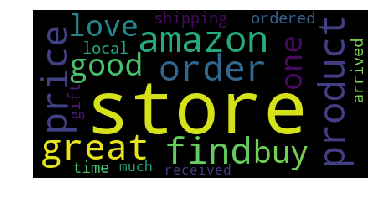

The most common 25 words in cluster 2 is: 


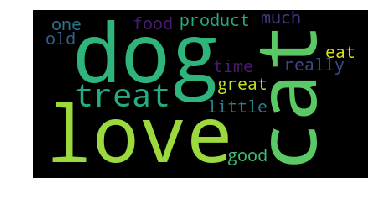

The most common 25 words in cluster 3 is: 


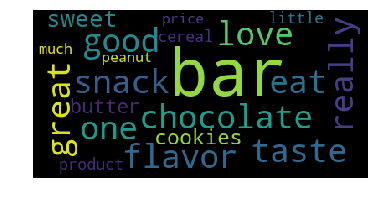

The most common 25 words in cluster 4 is: 


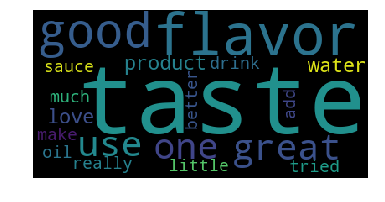

The most common 25 words in cluster 5 is: 


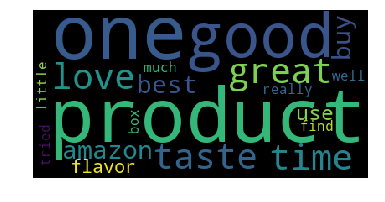

The most common 25 words in cluster 6 is: 


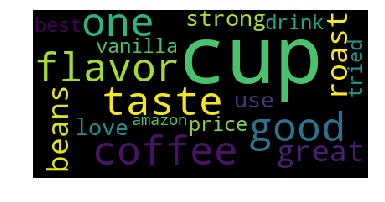

The most common 25 words in cluster 7 is: 


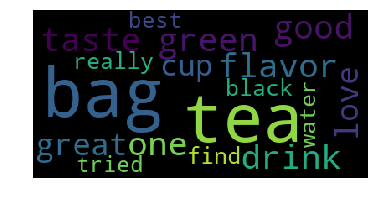

The most common 25 words in cluster 8 is: 


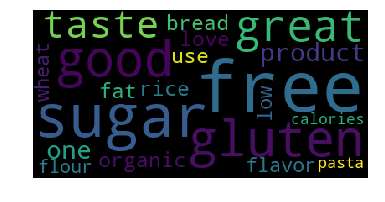

In [64]:
clust_words =[]
for i in range(n_clusters):
    clust_words.append(clust_text[i].split())

most_common_words = []

#count the occurence of each word in the cluster and sort the top 25 words 
#Source: https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list
for i in range(n_clusters):
    most_common_words.append([word for word, word_count in Counter(clust_words[i]).most_common(25)])
    top_text = " ".join(words for words in most_common_words[i])
    print("The most common 25 words in cluster {} is: ".format(i+1))
    generate_wordcloud(top_text)

In [65]:
#Lets try with 4 clusters
agg_clustering = AgglomerativeClustering(n_clusters=4)
agg_clustering.fit_predict(X_tfidfw2v)
print((agg_clustering.labels_))

[1 3 2 ... 2 3 1]


In [66]:
labels = agg_clustering.labels_.reshape(len(agg_clustering.labels_),1)
print(labels.shape)
clustered_text = np.concatenate((labels,text),axis=1)
print(clustered_text.shape)

(25000, 1)
(25000, 2)


In [67]:
# https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/43094244
#create a list of words for each cluster
n_clusters = 4
from collections import defaultdict

cluster_dict = defaultdict(list)
for key, val in clustered_text:
    cluster_dict[key].append(val)

clusters = cluster_dict.values()
clust_text = []
for i in clusters:
    clust_text.append(" ".join(i))
print(len(clust_text))

4


The most common 25 words in cluster 1 is: 


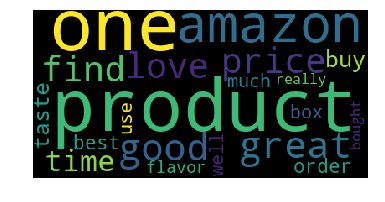

The most common 25 words in cluster 2 is: 


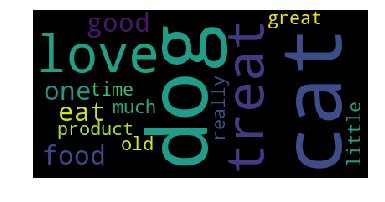

The most common 25 words in cluster 3 is: 


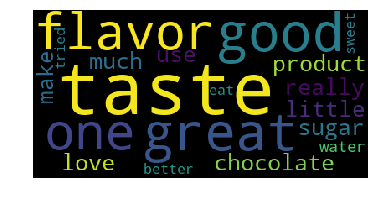

The most common 25 words in cluster 4 is: 


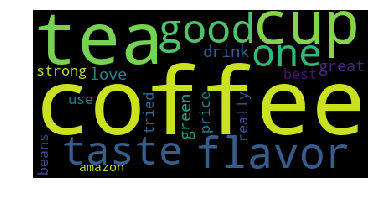

In [68]:
clust_words =[]
for i in range(n_clusters):
    clust_words.append(clust_text[i].split())

most_common_words = []

#count the occurence of each word in the cluster and sort the top 25 words 
#Source: https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list
for i in range(n_clusters):
    most_common_words.append([word for word, word_count in Counter(clust_words[i]).most_common(25)])
    top_text = " ".join(words for words in most_common_words[i])
    print("The most common 25 words in cluster {} is: ".format(i+1))
    generate_wordcloud(top_text)

In [69]:
#trying agg clustering with different number of clusters say 3
agg_clustering = AgglomerativeClustering(n_clusters=3)
agg_clustering.fit_predict(X_tfidfw2v)
print((agg_clustering.labels_))

[0 0 2 ... 2 0 0]


In [70]:
labels = agg_clustering.labels_.reshape(len(agg_clustering.labels_),1)
print(labels.shape)
clustered_text = np.concatenate((labels,text),axis=1)
print(clustered_text.shape)

(25000, 1)
(25000, 2)


In [71]:
# https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/43094244
#create a list of words for each cluster
n_clusters = 3
from collections import defaultdict

cluster_dict = defaultdict(list)
for key, val in clustered_text:
    cluster_dict[key].append(val)

clusters = cluster_dict.values()
clust_text = []
for i in clusters:
    clust_text.append(" ".join(i))
print(len(clust_text))

3


The most common 25 words in cluster 1 is: 


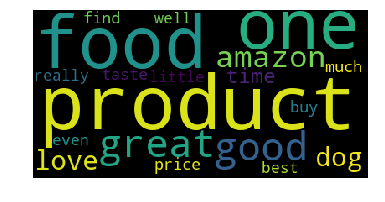

The most common 25 words in cluster 2 is: 


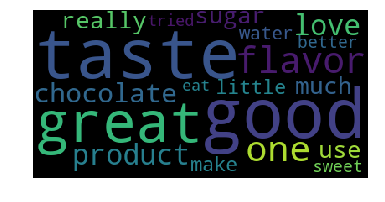

The most common 25 words in cluster 3 is: 


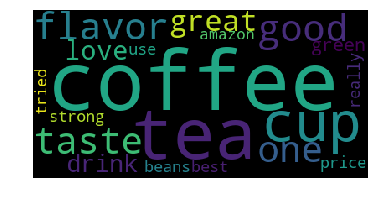

In [72]:
clust_words =[]
for i in range(n_clusters):
    clust_words.append(clust_text[i].split())

most_common_words = []

#count the occurence of each word in the cluster and sort the top 25 words 
#Source: https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list
for i in range(n_clusters):
    most_common_words.append([word for word, word_count in Counter(clust_words[i]).most_common(25)])
    top_text = " ".join(words for words in most_common_words[i])
    print("The most common 25 words in cluster {} is: ".format(i+1))
    generate_wordcloud(top_text)

Conclusion:
    1. Agglomerative Clustering was performed on TF-IDF Word2vec representation of AFF.
    2. We chose multiple cluster values like 2,3 and 5. we visualized these clusters using wordcloud.
    3. In a rare case like cluster 6, we could see words like drink,coffee,tea,green,cup,strong,flavor which could be pinned to 'beverage' category.Also Cluster 1 had words like buy,price,best,Amazon,local,store,love which could be pinned to 'shopping experience' category
    4. AS other clusters had a wide variety of words, it made it difficult to pin down to a particular category. This could be due to vey few points considered due to computational constraints or randomness in our data points. 

## [5.3] DBSCAN Clustering

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

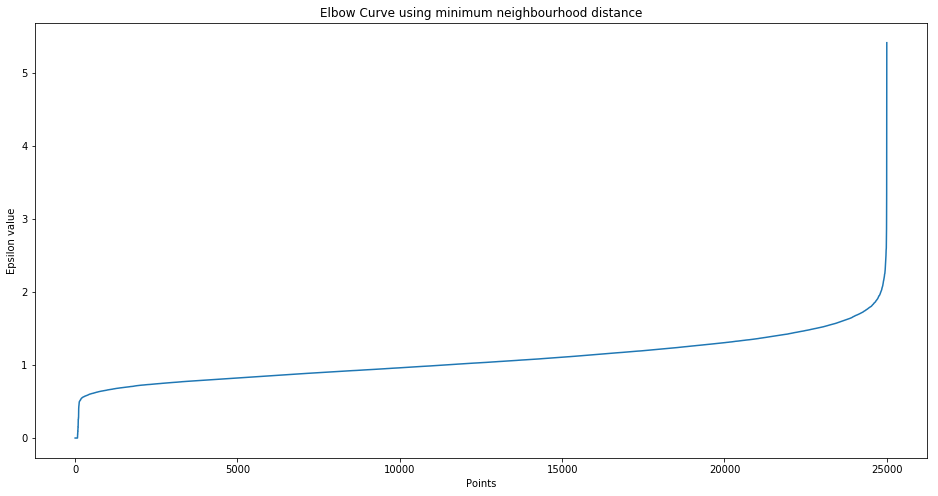

In [37]:
find_eps_dbscan(w2v_vectors)

In [38]:
#As from the above plot we can infer that 2 is the epsilon to be considered
db_clustering = DBSCAN(eps=2)
db_clustering.fit_predict(w2v_vectors)
print((db_clustering.labels_))

[0 0 0 ... 0 0 0]


In [40]:
text = final1['preprocessed_reviews'].to_numpy()
print(text.shape)

text = text.reshape(len(text),1)

labels = db_clustering.labels_.reshape(len(db_clustering.labels_),1)
print(labels.shape)
clustered_text = np.concatenate((labels,text),axis=1)
print(clustered_text.shape)

(25000,)
(25000, 1)
(25000, 2)


In [46]:
# https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/43094244
#create a list of words for each cluster

from collections import defaultdict

cluster_dict = defaultdict(list)
for key, val in clustered_text:
    cluster_dict[key].append(val)

clusters = cluster_dict.values()
n_clusters = len(cluster_dict.keys())

clust_text = []
for i in clusters:
    clust_text.append(" ".join(i))
print(len(clust_text))

2


The most common 25 words in cluster 1 is: 


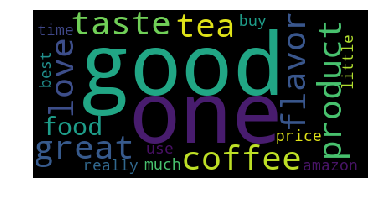

The most common 25 words in cluster 2 is: 


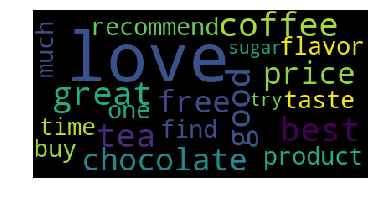

In [44]:
n_clusters = len(clust_text)
clust_words =[]
for i in range(n_clusters):
    clust_words.append(clust_text[i].split())

most_common_words = []

#count the occurence of each word in the cluster and sort the top 25 words 
#Source: https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list
for i in range(n_clusters):
    if(clust_words[i]):
        most_common_words.append([word for word, word_count in Counter(clust_words[i]).most_common(25)])
        top_text = " ".join(words for words in most_common_words[i])
        print("The most common 25 words in cluster {} is: ".format(i+1))
        generate_wordcloud(top_text)
    else:
        print("There are no words found in cluster {} ".format(i+1))

Conclusion:
    1. DBSCAN Clustering was performed on Word2vec representation of AFF.
    2. We chose Epsilon value to be 2 by plotting the elbow curve using the nearest neighbor distance for each point. 
    3. DBSCAN split the data points into 2 clusters. we visualized these clusters using wordcloud.
    4. In cluster 2, we could see words like chocolate,coffee,tea,sugar,dark,flavor which could be pinned to 'beverage' category. 

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

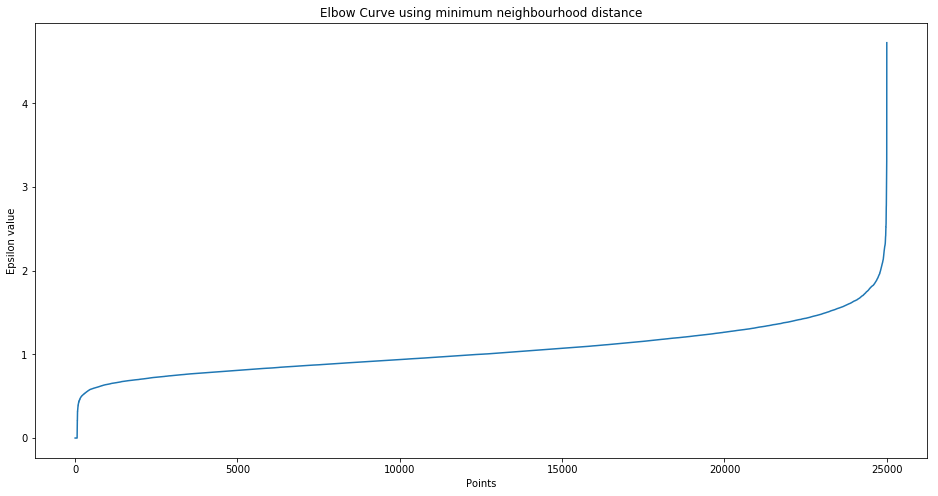

In [73]:
# Please write all the code with proper documentation
find_eps_dbscan(tfidf_w2v_vectors)

In [74]:
#As from the above plot we can infer that 2 is the epsilon to be considered
db_clustering = DBSCAN(eps=2)
db_clustering.fit_predict(tfidf_w2v_vectors)
print((db_clustering.labels_))

[0 0 0 ... 0 0 0]


In [75]:
labels = db_clustering.labels_.reshape(len(db_clustering.labels_),1)
print(labels.shape)
clustered_text = np.concatenate((labels,text),axis=1)
print(clustered_text.shape)

(25000, 1)
(25000, 2)


In [79]:
# https://stackoverflow.com/questions/38013778/is-there-any-numpy-group-by-function/43094244
#create a list of words for each cluster

from collections import defaultdict

cluster_dict = defaultdict(list)
for key, val in clustered_text:
    cluster_dict[key].append(val)

clusters = cluster_dict.values()
n_clusters = len(cluster_dict.keys())

clust_text = []
for i in clusters:
    clust_text.append(" ".join(i))
print(len(clust_text))
# print(cluster_dict[0])

2


The most common 25 words in cluster 1 is: 


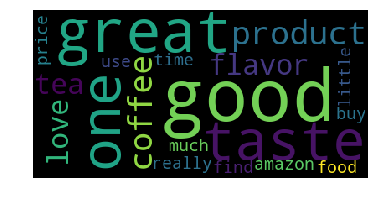

The most common 25 words in cluster 2 is: 


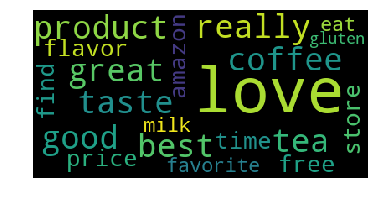

In [80]:
clust_words =[]
for i in range(n_clusters):
    clust_words.append(clust_text[i].split())

most_common_words = []

#count the occurence of each word in the cluster and sort the top 25 words 
#Source: https://stackoverflow.com/questions/3594514/how-to-find-most-common-elements-of-a-list
for i in range(n_clusters):
    if(clust_words[i]):
        most_common_words.append([word for word, word_count in Counter(clust_words[i]).most_common(25)])
        top_text = " ".join(words for words in most_common_words[i])
        print("The most common 25 words in cluster {} is: ".format(i+1))
        generate_wordcloud(top_text)
    else:
        print("There are no words found in cluster {} ".format(i+1))

Conclusion:
    1. DBSCAN Clustering was performed on TFIDF Word2vec representation of AFF.
    2. We chose Epsilon value to be 2 by plotting the elbow curve using the nearest neighbor distance for each point. 
    3. DBSCAN split the data points into 2 clusters. we visualized these clusters using wordcloud.
    4. AS the clusters had a wide variety of words, it made it difficult to pin down to a particular category. 

# [6] Conclusions

In [81]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable
    
x = PrettyTable(["METRIC", "B.O.W", "TF-IDF", "Avg w2v", "TF-IDF w2v", "Clustering type" ])

x.add_row(["Cluster size",50,50,50,20,"K Means" ])
x.add_row(["Cluster size",'NA','NA','8,4,3','8,4,3',"Agglomerative" ])
x.add_row(["Cluster size",'NA','NA',2,2,"DBSCAN"])
x.add_row(["Epsilon",'NA','NA',2.0,2.0,"DBSCAN"])

print(x)

+--------------+-------+--------+---------+------------+-----------------+
|    METRIC    | B.O.W | TF-IDF | Avg w2v | TF-IDF w2v | Clustering type |
+--------------+-------+--------+---------+------------+-----------------+
| Cluster size |   50  |   50   |    50   |     20     |     K Means     |
| Cluster size |   NA  |   NA   |  8,4,3  |   8,4,3    |  Agglomerative  |
| Cluster size |   NA  |   NA   |    2    |     2      |      DBSCAN     |
|   Epsilon    |   NA  |   NA   |   2.0   |    2.0     |      DBSCAN     |
+--------------+-------+--------+---------+------------+-----------------+
